# Making SINDy Neural

In [ ]:
# Imports
import numpy as np
import math
import torch
import torch.optim as optim
import torch.nn as nn
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

## Neural Network Class

In [ ]:
# Fully-connected network:
class fc_net(torch.nn.Module):
# Network Structure:
# Fully Connected -> ReLu -> Fully Connected -> Linear

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out, w1):
    super(fc_net, self).__init__()
    self.h1 = torch.nn.Linear(in_features=num_in, out_features=w1) # Fully-connected layer
    self.h2 = torch.nn.Linear(in_features=w1, out_features=1) # Fully-connected layer

  # Build the network:
  def forward(self, inputs):
    a1 = F.relu(self.h1(inputs)) # ReLu activation
    a2 = self.h2(a1) # Linear activation
    # a2 = F.sigmoid(self.h2(a1),dim=-1) # Sigmoid activation
    return a2

  # L1 loss:
  def L1_loss(self, w):
    return torch.abs(w).sum()
  
  # L2 loss:
  def L2_loss(self, w):
    return torch.square(w).sum()

In [ ]:
class MaskedLinearLayer(torch.nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias=False, keep_layer_input=False):
        """
        :param in_feature: Number of input features
        :param out_features: Output features in analogy to torch.nn.Linear
        :param bias: Iff each neuron in the layer should have a bias unit as well.
        """
        super().__init__(in_features, out_features, bias)

        self.register_buffer('mask', torch.ones((out_features, in_features), dtype=torch.bool))
        self.keep_layer_input = keep_layer_input
        self.layer_input = None

    def forward(self, input):
        x = input.float()  # In case we get a double-tensor passed, force it to be float for multiplications to work

        # Possibly store the layer input
        if self.keep_layer_input:
            self.layer_input = x.data

        return F.linear(x, self.weight * self.mask, self.bias)

    def compute_mask(self):
      mask_idx = torch.where(self.mask[0] == True)[0]
      weight_idx = torch.argmin(abs(self.weight[0][mask_idx]))
      idx = mask_idx[weight_idx]
      self.mask[0][idx] = False
      with torch.no_grad():
        self.weight[0][idx] = 0 # Set weight term to zero out to zero
        # self.weight[0] = self.weight[0]*self.mask[0] # Multiply weights by mask

    # def compute_mask(self):
    #   idx = torch.where(abs(self.weight[0]) > 0)
    #   self.mask[0][torch.argmin(abs(self.weight))] = False

In [ ]:
# torch.argmin(abs(model.h1.weight))
# model.h1.mask[0]
# print(abs(model.h1.weight))
# torch.where(model.h1.mask[0] > 0)
# # idx = torch.where(abs(model.h1.mask[0]) > 0)
# # model.h1.weight[0][idx]

In [ ]:
# Linear network:
class lin_net(torch.nn.Module):

  # Initialize the network and specify input/output dimensions:
  def __init__(self, num_in, num_out, w1):
    super(lin_net, self).__init__()
    # self.h1 = torch.nn.Linear(in_features=num_in, out_features=w1) # Fully-connected layer
    self.h1 = MaskedLinearLayer(in_features=num_in, out_features=w1) # Masked linear
    
  # Build the network:
  def forward(self, inputs):
    a1 = self.h1(inputs) # Linear activation
    return a1

  # L1 loss:
  def L1_loss(self, w):
    return torch.abs(w).sum()
  
  # L2 loss:
  def L2_loss(self, w):
    return torch.square(w).sum()

  # def compute_mask(self):
  #   self.mask[torch.argmin(abs(self.h1.weight))] = False

  # def f_prune(self, w):
  #   self.mask = torch.ones(
  #       w.shape, dtype=torch.bool, device=self.mask.device
  #   )
  #   self.mask[torch.argmin(abs(w))] = False

  # def recompute_mask(self, theta: float = 0.001):
  #   self.mask = torch.ones(
  #       self.weight.shape, dtype=torch.bool, device=self.mask.device
  #   )
  #   self.mask[torch.where(abs(self.weight) < theta)] = False

In [ ]:
# mask = torch.ones(model.h1.weight.shape, dtype=torch.bool)
# def compute_mask(self,mask):
#   mask[0][torch.argmin(abs(self.h1.weight))] = False
#   return mask

# mask = compute_mask(model,mask)
# mask*model.h1.weight

In [ ]:
# Train the model:
def train(model,loss,train_loader,optimizer,epoch,losses):
  model.train()
  # print('Train Epoch: ', epoch)
  for batch_idx, (cur_x, cur_y) in enumerate(train_loader):

    optimizer.zero_grad() # Zero out gradients
    output = model.forward(cur_x) # Propagate forward through network
    cur_loss = loss(output, cur_y) # Compute loss at current iteration
    
    # ----------------------
    # Add L1 loss:
    l1_weight = 1
    parameters = []
    for parameter in model.parameters():
        parameters.append(parameter.view(-1))
    l1_norm = l1_weight * model.L1_loss(torch.cat(parameters))
    # l2_norm = l2_weight * model.L2_loss(torch.cat(parameters))
    cur_loss += l1_weight*l1_norm
    # ----------------------

    cur_loss.backward() # Backprop
    optimizer.step() # Step of optimizer
    losses.append(cur_loss.cpu().detach().numpy())

  return losses

    # if np.mod(batch_idx+1,it) == 0:
    #   print('Iteration: ', batch_idx+1, ' Loss: ', round(cur_loss.item(),5))

In [ ]:
# Plot the loss:
def f_Plot_loss(losses):
  plt.plot(losses, '-', color = "black")
  plt.title('Training Loss')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.grid()
  plt.show()

## Test on sinusoidal data

In [ ]:
# # Create sinusoidal training data:
# train_batch_sz = 10 # Size of training batch
# data_range = 15
# x1 = (np.random.uniform(0,data_range, size=(data_range*100, 1)))-data_range/2
# # x2 = x1*0
# # x3 = x1*0
# x2 = 2*x1 + 3
# x3 = x1**2 - x2

# # Create training labels:
# frq = 2
# y = np.sin(frq*x1)

# train_1 = np.column_stack((x1,x2,x3))
# labels = np.reshape(y,(len(y),1))

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Convert to torch tensors:
# # train_data= torch.from_numpy(x1).float().to(device)
# # train_labels = torch.from_numpy(y).float().to(device)

# train_data = torch.from_numpy(train_1).float().to(device) # as torch.float32
# train_labels = torch.from_numpy(labels).float().to(device)

# # Create dataset from tensors with matching first dimension
# # Samples will be drawn from the first dimension
# train_dataset = TensorDataset(train_data, train_labels)

# # Create a data loader from the dataset
# # Type of sampling and batch size are specified at this step
# train_loader = DataLoader(train_dataset, batch_size=train_batch_sz, shuffle=False)

# # Create an iterator on the training loader
# # (this is just to test the size of x_train and y_train)
# cur_x, cur_y = next(iter(train_loader))
# print(cur_x.size()) # x_train for current iteration
# print(cur_y.size()) # y_train for current iteration

# # variables for plotting results
# res = 10
# x1_t = (np.arange(data_range*res)-data_range/2*res).reshape(data_range*res,1)/res
# # x2_t = x1_t*0
# # x3_t = x1_t*0
# x2_t = 2*x1_t + 3
# x3_t = x1_t**2 - x2_t
# train_t = np.column_stack((x1_t,x2_t,x3_t))
# x1_t_torch = torch.from_numpy(x1_t).float().to(device)
# x_axis_torch = torch.from_numpy(train_t).float().to(device)

In [ ]:
# lr = 2e-3 # Learning rate
# n_epochs = 50 # Number of training epochs
# plot_every = n_epochs/5 # Plot five times

# num_in = 3 # Dimension of input
# num_out = 1 # Dimension of output

# w1 = 200 # Width of hidden layer 1

# losses = [] # Array of training losses

# model = fc_net(num_in, num_out, w1).to(device)
# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# # opt = torch.optim.SGD(model.parameters(), lr=lr) # SGD
# # opt = torch.optim.SGD(model.parameters(), lr=lr), momentum=0.4) # SGD with momentum
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam

# for epoch in np.arange(n_epochs)+1:
#   train(model,loss,losses,train_loader,opt,epoch)

#   if (epoch % plot_every) == 0:
#     labels = (np.sin(frq*x1_t_torch.cpu())).detach().numpy()
#     labels_hat = model(x_axis_torch).cpu().detach().numpy()
# #     labels = (np.sin(frq*x_axis_torch.cpu())).detach().numpy()
# #     labels_hat = model(x_axis_torch).cpu().detach().numpy()

#     plt.plot(labels)
#     plt.plot(labels_hat)
#     plt.grid()
#     plt.show()

# f_Plot_loss(losses)

## Simulate Lorenz system

In [ ]:
## Solves the Lorenz system's equations of motion:
def f_DynamicSim(X0,tf,dt=0.01,t0=0,sigma=10,beta=8/3,rho=28):

    Nt = int(tf/dt) + 1 # Number of time steps
    Xi = X0 # Initialize state at ith time step
    XN = np.zeros((3,Nt)) # Initialize vector of nominal states
    XP = np.zeros((3,Nt)) # Initialize vector of derivatives
    XN[:,0] = X0 # Initial conditions

    i = 0 # Initialize iteration counter
    ti = t0 # Initialize time counter
    # Iterate over time interval:
    # (At final time step: i+1 = tf/dt, where i = ti/dt => ti = tf - dt)
    while ti <= tf-dt:
        # Update derivative using the equations of motion
        Xp = np.array([sigma*(Xi[1]-Xi[0]), Xi[0]*(rho-Xi[2])-Xi[1], Xi[0]*Xi[1]-beta*Xi[2]])
        Xi = Xi + Xp*dt # Update state at ith time step

        XN[:,i+1] = Xi # Update nominal state
        XP[:,i] = Xp # Update nominal state
        i += 1 # Increment counter
        ti += dt # Increment timer

    XP[:,tf] = np.array([sigma*(Xi[1]-Xi[0]), Xi[0]*(rho-Xi[2])-Xi[1], Xi[0]*Xi[1]-beta*Xi[2]])
        
    # Ouput: Nominal state & derivative
    return XN, XP

In [ ]:
# Run the dynamic model:
tf = 15
X0 = np.array([10,10,10])
XN, XP = f_DynamicSim(X0,tf,dt=0.01)
len(XN[0])

1501

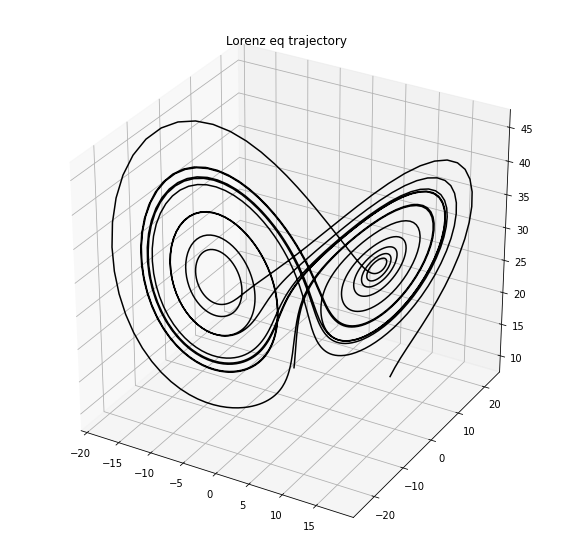

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot3D(XN[0], XN[1], XN[2], 'k')
ax.set_title('Lorenz eq trajectory')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection ='3d')
# ax.plot3D(XP[0], XP[1], XP[2], 'k')
# ax.set_title('Lorenz deriv. trajectory')
# plt.show()

In [ ]:
# Get testing data:
X0_2 = np.array([9,11,9])
XN_2, XP_2 = f_DynamicSim(X0_2,tf,dt=0.01)

# fig = plt.figure()
# ax = plt.axes(projection ='3d')
# ax.plot3D(XN_2[0], XN_2[1], XN_2[2], 'k')
# ax.set_title('Lorenz eq trajectory')
# plt.show()

# fig = plt.figure()
# ax = plt.axes(projection ='3d')
# ax.plot3D(XP_2[0], XP_2[1], XP_2[2], 'k')
# ax.set_title('Lorenz deriv. trajectory')
# plt.show()

## Train neural net on Lorenz data

In [ ]:
# # Create training data:
# train_batch_sz = 10 # Size of training batch

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Convert to torch tensors:
# train_data = torch.from_numpy(XN.T).float().to(device) # as torch.float32
# train_labels = torch.from_numpy(np.reshape(XP[0],(len(XP[0]),1))).float().to(device)

# # Create dataset from tensors with matching first dimension
# # Samples will be drawn from the first dimension
# train_dataset = TensorDataset(train_data, train_labels)

# # Create a data loader from the dataset
# # Type of sampling and batch size are specified at this step
# train_loader = DataLoader(train_dataset, batch_size=train_batch_sz, shuffle=False)

# # Create an iterator on the training loader
# # (this is just to test the size of x_train and y_train)
# cur_x, cur_y = next(iter(train_loader))
# print(cur_x.size()) # x_train for current iteration
# print(cur_y.size()) # y_train for current iteration

In [ ]:
# lr = 2e-3 # Learning rate
# n_epochs = 10 # Number of training epochs
# plot_every = n_epochs/5 # Plot five times

# num_in = 3 # Dimension of input
# num_out = 1 # Dimension of output

# w1 = 200 # Width of hidden layer 1

# losses = [] # Array of training losses

# model = fc_net(num_in, num_out, w1).to(device)
# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# # opt = torch.optim.SGD(model.parameters(), lr=lr) # SGD
# # opt = torch.optim.SGD(model.parameters(), lr=lr), momentum=0.4) # SGD with momentum
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam

# for epoch in np.arange(n_epochs)+1:
#   train(model,loss,losses,train_loader,opt,epoch)

#   if (epoch % plot_every) == 0:
# #     labels_hat = model(train_data).cpu().detach().numpy()
#     test_labels = torch.from_numpy(np.reshape(XP_2[0],(len(XP_2[0]),1))).float().to(device)
#     labels_hat = model(torch.from_numpy(XN_2.T).float().to(device)).cpu().detach().numpy()
    
# #     plt.plot(train_labels)
#     plt.plot(test_labels)
#     plt.plot(labels_hat)
#     plt.grid()
#     plt.show()

# f_Plot_loss(losses)

## More general code

In [ ]:
def f_Training_Data(XN,XP,dim,train_batch_sz=10):

  # Create training data:
  train_batch_sz = 10 # Size of training batch

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # Convert to torch tensors:
  train_data = torch.from_numpy(XN.T).float().to(device) # as torch.float32
  train_labels = torch.from_numpy(np.reshape(XP[dim],(len(XP[dim]),1))).float().to(device)

  # Create dataset from tensors with matching first dimension
  # Samples will be drawn from the first dimension
  train_dataset = TensorDataset(train_data, train_labels)

  # Create a data loader from the dataset
  # Type of sampling and batch size are specified at this step
  train_loader = DataLoader(train_dataset, batch_size=train_batch_sz, shuffle=False)

  # Create an iterator on the training loader
  # (this is just to test the size of x_train and y_train)
  cur_x, cur_y = next(iter(train_loader))
  print(cur_x.size()) # x_train for current iteration
  print(cur_y.size()) # y_train for current iteration

  return train_loader

In [ ]:
def f_Train_Model(train_loader,XN_2,XP_2,dim,num_in,num_out,w1,model,loss,opt,lr=2e-3,n_epochs=10,window=301):

  losses = [] # Array of training losses

  plot_every = n_epochs/5

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device)
  d = (max(test_labels)-min(test_labels))[0]

  epoch_reset = 0
  for epoch in np.arange(n_epochs)+1:
    losses = train(model,loss,train_loader,opt,epoch,losses)
    epoch_reset += 1

    # if sum(losses[-window:])/sum(losses[0:window]) < 0.02 and epoch_reset >= 10:
    if np.sqrt(sum(losses[-window:])/window)/d < 0.04 and epoch_reset >= 10:
      epoch_reset = 0
    # if (epoch % plot_every) == 0:
  #     labels_hat = model(train_data).cpu().detach().numpy()
      f_display_weights(model)
      print("Number of iterations:", len(losses))
      # print("Time-averaged loss:",sum(losses[-window:])/sum(losses[0:window]))
      print("Time-averaged loss:",np.sqrt(sum(losses[-window:])/window)/d)

      test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device)
      labels_hat = model(torch.from_numpy(XN_2.T).float().to(device)).cpu().detach().numpy()
      opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam

  #     plt.plot(train_labels)
      plt.plot(test_labels)
      plt.plot(labels_hat)
      plt.grid()
      plt.show()

      model.h1.compute_mask()

  f_display_weights(model)
  print("Number of iterations:", len(losses))
  print("Time-averaged loss:",np.sqrt(sum(losses[-window:])/window)/d)
  plt.plot(test_labels)
  plt.plot(labels_hat)
  plt.grid()
  plt.show()

  return losses

In [ ]:
# window = 301
# test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device)
# d = (max(test_labels)-min(test_labels))[0]
# np.sqrt(sum(losses[-window:])/window)/d

In [ ]:
def f_display_weights(model):
  
  print("weight:",model.h1.weight)
  print("bias:",model.h1.bias)
  print("mask:",model.h1.mask)
  # print(model.h1.weight * model.h1.mask)
  
  # W = []
  # for param in model.parameters():
  #   W.append(param.data.cpu().detach().numpy())
  # print("Weights:", W[0][0])
  # print(W[1][0])

  # idx = np.flip(np.argsort(np.abs(W[0][0])))
  # print("Weight Indices:",idx)
  # plt.plot(np.arange(len(idx)),np.flip(np.sort(np.abs(W[0][0]))))
  # plt.scatter(np.arange(len(idx)),np.flip(np.sort(np.abs(W[0][0]))))
  # np.argmin(np.abs(W[0][0]),4)

  # We want:
  # x1 = [-sigma sigma 0 0 0 0 0 0 0 0]
  # x2 = [rho -1 0 0 0 0 0 -1 0 0]
  # x3 = [0 0 -beta 0 0 0 1 0 0 0]
  # where sigma=10,beta=2.666,rho=28

  # X_poly = np.column_stack((XN.T,XN.T**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1)).T
  # Xp = np.array([sigma*Xi[1]-sigma*Xi[0], rho*Xi[0] - Xi[1] - Xi[0]*Xi[2], Xi[0]*Xi[1]-beta*Xi[2]])"weight:",

In [ ]:
# Test on fc_net

# dim = 2
# num_in = 3
# num_out = 1
# w1 = 200
# lr = 2e-3
# n_epochs = 20

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = fc_net(num_in, num_out, w1).to(device)
# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# # opt = torch.optim.SGD(model.parameters(), lr=lr) # SGD
# # opt = torch.optim.SGD(model.parameters(), lr=lr), momentum=0.4) # SGD with momentum
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam

# train_loader = f_Training_Data(XN,XP,dim=dim)
# losses = f_Train_Model(train_loader,XN_2,XP_2,dim=dim,num_in=num_in,num_out=num_out,w1=w1,model=model,loss=loss,opt=opt,lr=lr,n_epochs=n_epochs)
# f_Plot_loss(losses)

## SINDy

torch.Size([10, 10])
torch.Size([10, 1])
weight: Parameter containing:
tensor([[-4.6848e-01,  4.8485e-01, -2.0738e-01, -2.2339e-04, -4.1062e-02,
          6.4154e-03,  6.1753e-02, -2.5874e-01,  2.8793e-01,  1.6987e-01]],
       requires_grad=True)
bias: None
mask: tensor([[True, True, True, True, True, True, True, True, True, True]])
Number of iterations: 1963
Time-averaged loss: tensor(0.0387)


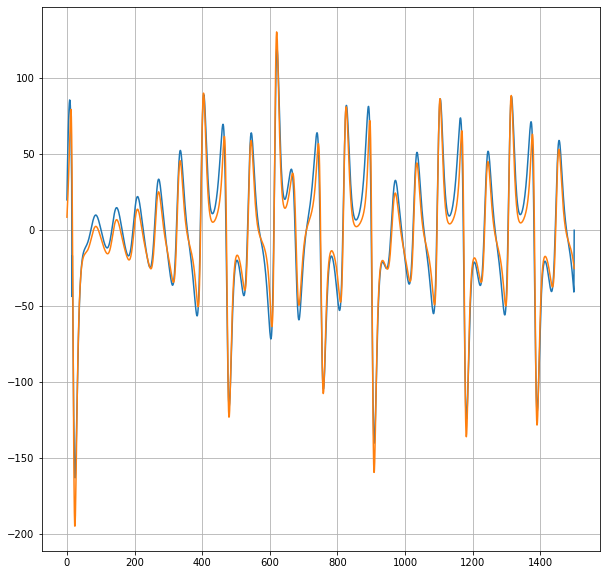

weight: Parameter containing:
tensor([[-0.1592,  0.9717, -0.1251,  0.0000, -0.0187,  0.0016,  0.0243, -0.2786,
          0.2825,  0.1233]], requires_grad=True)
bias: None
mask: tensor([[ True,  True,  True, False,  True,  True,  True,  True,  True,  True]])
Number of iterations: 3473
Time-averaged loss: tensor(0.0325)


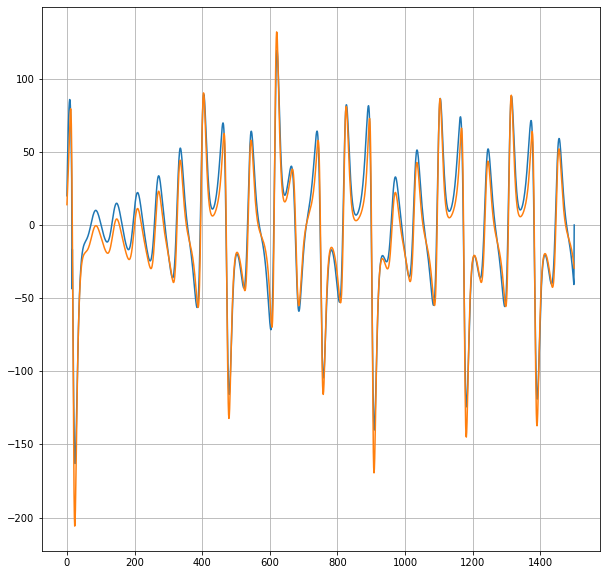

weight: Parameter containing:
tensor([[ 0.0660,  1.4090, -0.0121,  0.0000, -0.0130,  0.0000,  0.0220, -0.2854,
          0.2630,  0.0157]], requires_grad=True)
bias: None
mask: tensor([[ True,  True,  True, False,  True, False,  True,  True,  True,  True]])
Number of iterations: 4983
Time-averaged loss: tensor(0.0301)


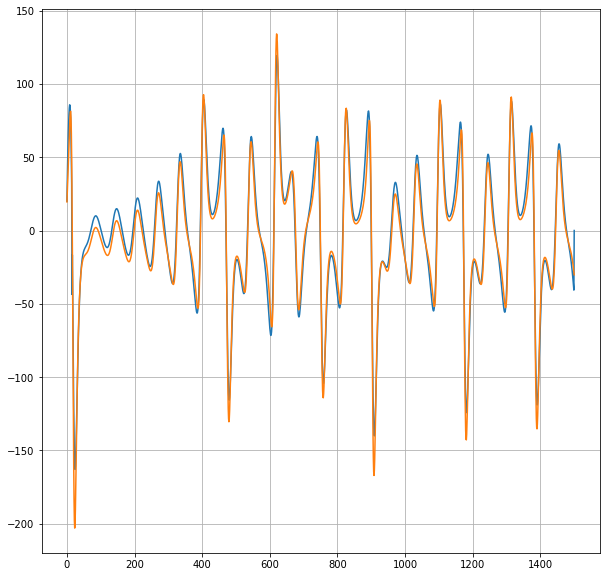

weight: Parameter containing:
tensor([[ 2.0140e-01,  1.7990e+00,  0.0000e+00,  0.0000e+00, -9.7855e-03,
          0.0000e+00,  1.4916e-02, -2.8669e-01,  2.4611e-01, -1.7330e-03]],
       requires_grad=True)
bias: None
mask: tensor([[ True,  True, False, False,  True, False,  True,  True,  True,  True]])
Number of iterations: 6493
Time-averaged loss: tensor(0.0282)


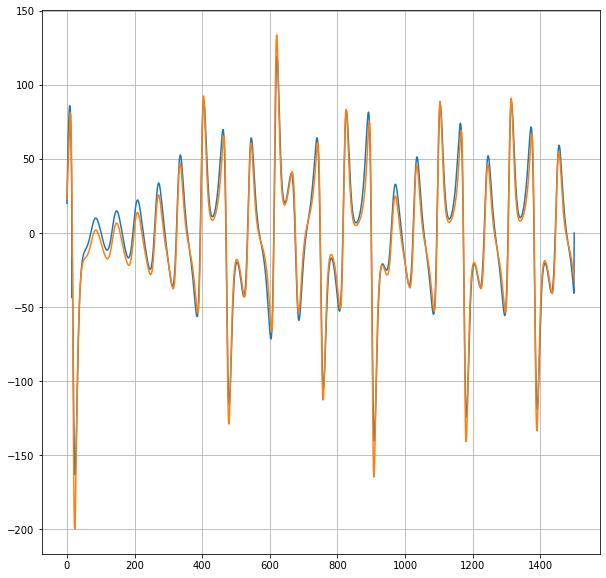

weight: Parameter containing:
tensor([[ 0.2734,  2.1300,  0.0000,  0.0000, -0.0077,  0.0000,  0.0116, -0.2865,
          0.2319,  0.0000]], requires_grad=True)
bias: None
mask: tensor([[ True,  True, False, False,  True, False,  True,  True,  True, False]])
Number of iterations: 8003
Time-averaged loss: tensor(0.0270)


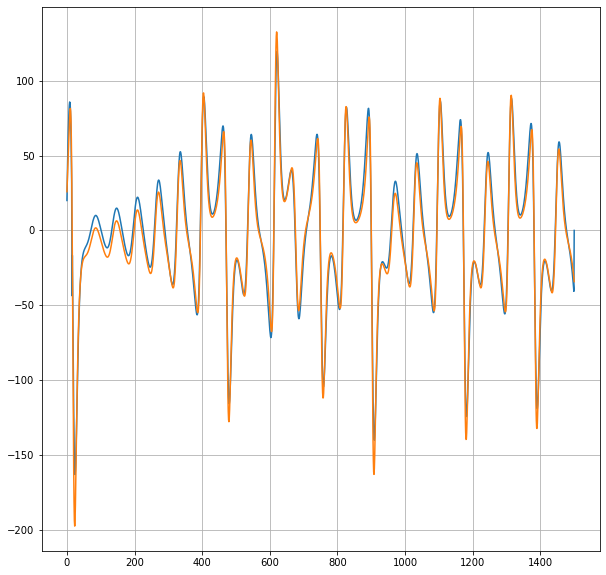

weight: Parameter containing:
tensor([[ 0.2785,  2.3998,  0.0000,  0.0000,  0.0000,  0.0000,  0.0047, -0.2852,
          0.2199,  0.0000]], requires_grad=True)
bias: None
mask: tensor([[ True,  True, False, False, False, False,  True,  True,  True, False]])
Number of iterations: 9513
Time-averaged loss: tensor(0.0265)


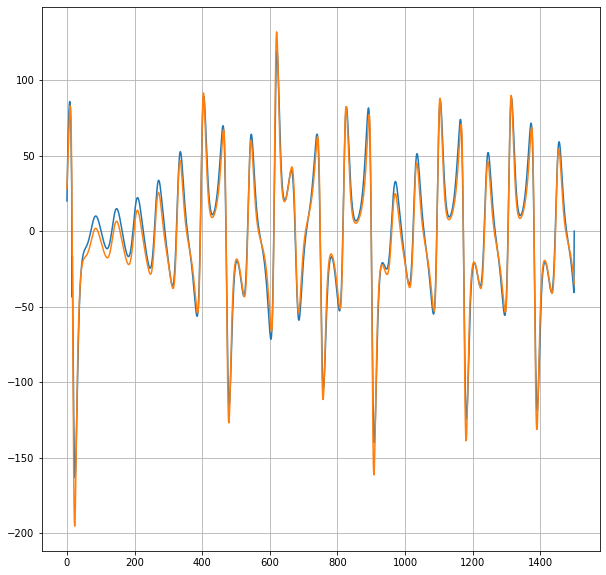

weight: Parameter containing:
tensor([[ 0.2327,  2.6165,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2829,
          0.2104,  0.0000]], requires_grad=True)
bias: None
mask: tensor([[ True,  True, False, False, False, False, False,  True,  True, False]])
Number of iterations: 11023
Time-averaged loss: tensor(0.0265)


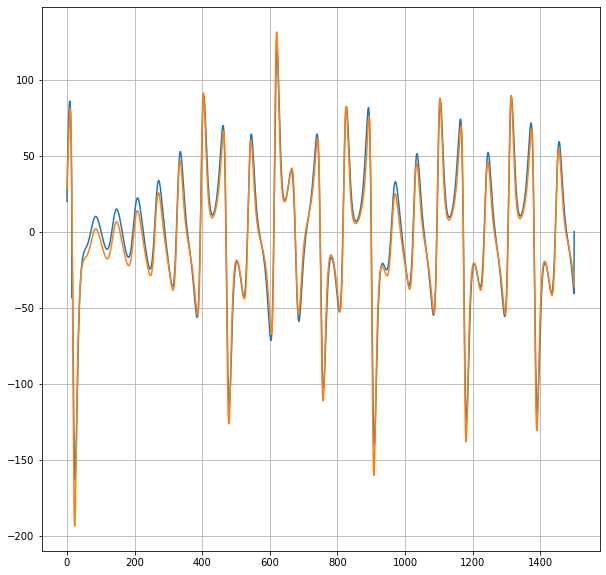

weight: Parameter containing:
tensor([[-0.2888,  7.0007,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.2161,
          0.0000,  0.0000]], requires_grad=True)
bias: None
mask: tensor([[ True,  True, False, False, False, False, False,  True, False, False]])
Number of iterations: 20989
Time-averaged loss: tensor(0.0400)


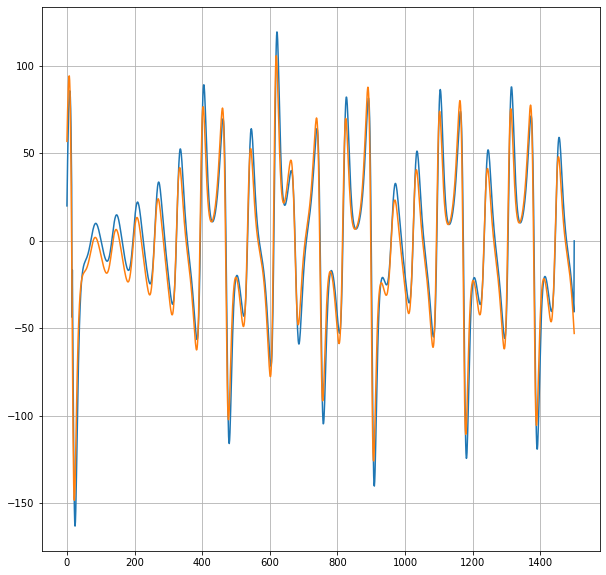

weight: Parameter containing:
tensor([[-7.4646,  7.8182,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]], requires_grad=True)
bias: None
mask: tensor([[ True,  True, False, False, False, False, False, False, False, False]])
Number of iterations: 31710
Time-averaged loss: tensor(0.0395)


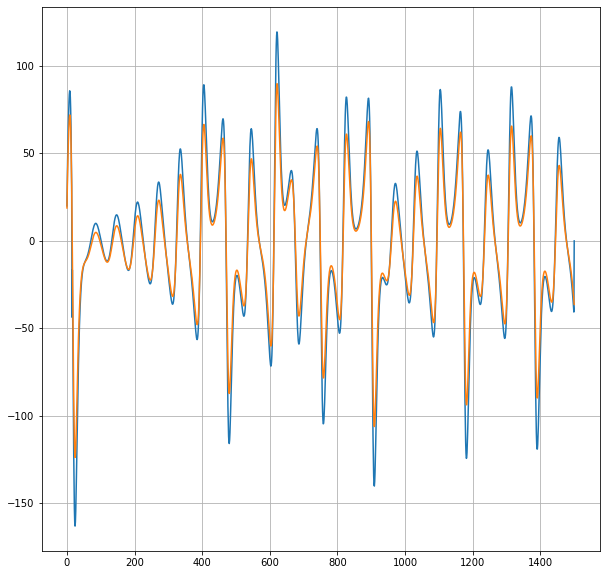

weight: Parameter containing:
tensor([[0.0000, 2.1209, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], requires_grad=True)
bias: None
mask: tensor([[False,  True, False, False, False, False, False, False, False, False]])
Number of iterations: 45300
Time-averaged loss: tensor(0.1399)


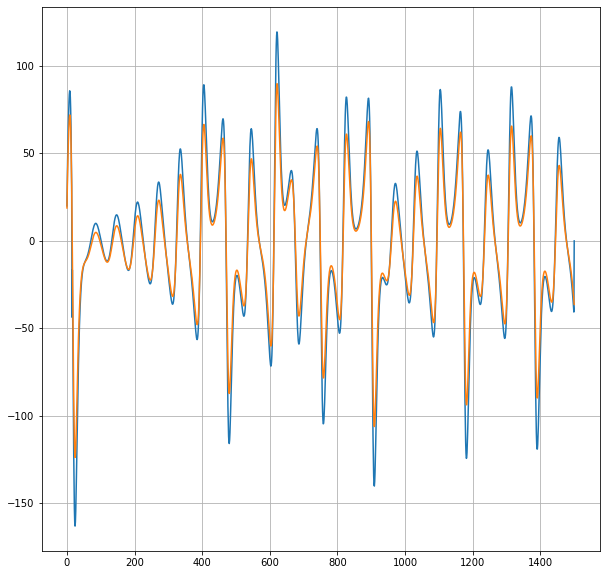

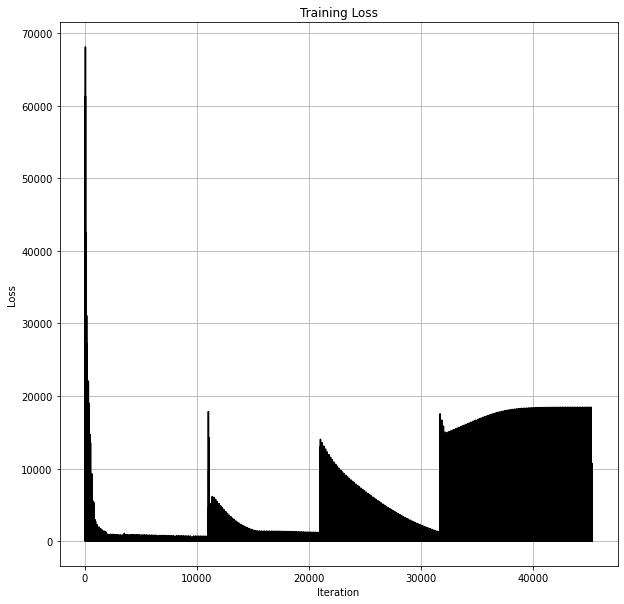

In [ ]:
# Every second-order term:
# X_poly = np.column_stack((XN.T,XN.T**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1)).T
# X_poly_2 = np.column_stack((XN_2.T,XN_2.T**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1)).T
X_poly = np.column_stack((XN[0],XN[1],XN[2],XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1)).T
X_poly_2 = np.column_stack((XN_2[0],XN_2[1],XN_2[2],XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1)).T

# X_poly = np.column_stack((XN[0],XN[1])).T
# X_poly_2 = np.column_stack((XN_2[0],XN_2[1])).T

dim = 0
num_in = len(X_poly)
# print(num_in)
num_out = 1
w1 = 1
lr = 2e-3
n_epochs = 300

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = lin_net(num_in, num_out, w1).to(device)
loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# Reset optimizer; otherwise, momentum terms will make zeroed-out terms nonzero:
opt = torch.optim.Adam(model.parameters(), lr=lr)

train_loader = f_Training_Data(X_poly,XP,dim=dim)
losses = f_Train_Model(train_loader,X_poly_2,XP_2,dim=dim,num_in=num_in,num_out=num_out,w1=w1,model=model,loss=loss,opt=opt,lr=lr,n_epochs=n_epochs)
f_Plot_loss(losses)

tensor([0.0989])


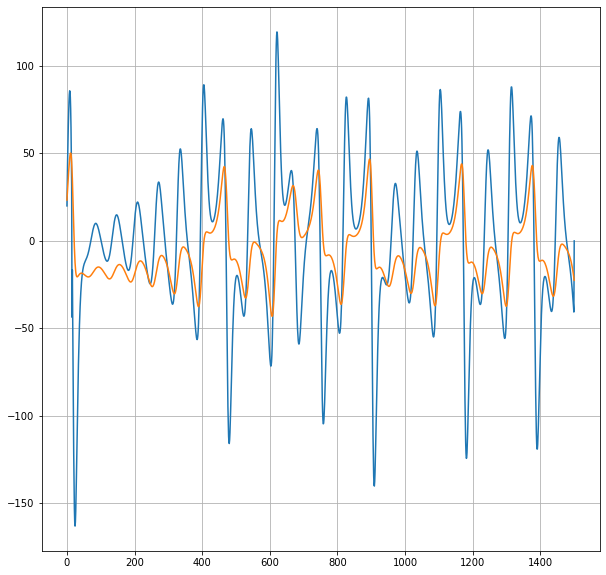

In [ ]:
test_labels = torch.from_numpy(np.reshape(XP_2[dim],(len(XP_2[dim]),1))).float().to(device)
labels_hat = model(torch.from_numpy(X_poly_2.T).float().to(device)).cpu().detach().numpy()

delta = 1/((max(test_labels)-min(test_labels))*len(test_labels))

MSE = sum(abs(test_labels-labels_hat))/len(test_labels)/(max(test_labels)-min(test_labels))
print(MSE)

plt.plot(test_labels)
plt.plot(labels_hat)
plt.grid()
plt.show()

## Trash

In [ ]:
# # for i in np.arange(10):
# print(model.h1.weight)
# print(model.h1.mask)

# mask_idx = torch.where(model.h1.mask[0] == True)[0]
# print(mask_idx)
# print(abs(model.h1.weight[0][mask_idx]))
# weight_idx = torch.argmin(abs(model.h1.weight[0][mask_idx]))
# idx = mask_idx[weight_idx]
# model.h1.mask[0][idx] = False
# with torch.no_grad():
#   model.h1.weight[0][idx] = 0

# print(model.h1.weight)
# print(model.h1.mask)

In [ ]:
# class MaskedLinearLayer(torch.nn.Linear):
#     def __init__(self, in_features: int, out_features: int, bias=False, keep_layer_input=False):
#         """
#         :param in_feature: Number of input features
#         :param out_features: Output features in analogy to torch.nn.Linear
#         :param bias: Iff each neuron in the layer should have a bias unit as well.
#         """
#         super().__init__(in_features, out_features, bias)

#         self.register_buffer('mask', torch.ones((out_features, in_features), dtype=torch.bool))
#         self.keep_layer_input = keep_layer_input
#         self.layer_input = None

#     def forward(self, input):
#         x = input.float()  # In case we get a double-tensor passed, force it to be float for multiplications to work

#         # Possibly store the layer input
#         if self.keep_layer_input:
#             self.layer_input = x.data

#         return F.linear(x, self.weight * self.mask, self.bias)

#     def compute_mask(self):
#       mask_idx = torch.where(self.mask[0] == True)
#       weight_idx = torch.argmin(abs(self.weight[0][mask_idx]))
#       self.mask[0][weight_idx] = False
#       with torch.no_grad():
#         self.weight[0][weight_idx] = 0

#     # def compute_mask(self):
#     #   idx = torch.where(abs(self.weight[0]) > 0)
#     #   self.mask[0][torch.argmin(abs(self.weight))] = False

In [ ]:
# class MaskedLinearLayer(torch.nn.Linear):
#     def __init__(self, in_features: int, out_features: int, bias=False, keep_layer_input=False):
#         """
#         :param in_feature: Number of input features
#         :param out_features: Output features in analogy to torch.nn.Linear
#         :param bias: Iff each neuron in the layer should have a bias unit as well.
#         """
#         super().__init__(in_features, out_features, bias)

#         self.register_buffer('mask', torch.ones((out_features, in_features), dtype=torch.bool))
#         self.keep_layer_input = keep_layer_input
#         self.layer_input = None

#     def forward(self, input):
#         x = input.float()  # In case we get a double-tensor passed, force it to be float for multiplications to work

#         # Possibly store the layer input
#         if self.keep_layer_input:
#             self.layer_input = x.data

#         return F.linear(x, self.weight * self.mask, self.bias)

#     def compute_mask(self):
#       mask_idx = torch.where(self.mask[0] == True)
#       weight_idx = torch.argmin(abs(self.weight[0][mask_idx]))
#       self.mask[0][weight_idx] = False
#       with torch.no_grad():
#         self.weight[0][weight_idx] = 0

#     # def compute_mask(self):
#     #   idx = torch.where(abs(self.weight[0]) > 0)
#     #   self.mask[0][torch.argmin(abs(self.weight))] = False

In [ ]:
# n = 301

# L = []
# avg_v = []
# for i in np.arange(len(losses)):
#   L.append(losses[i])
#   if i > n:
#     avg = sum(L[-n:])/n
#     avg_v.append(avg)
#     # if avg/avg_v[0] < 0.05:
#     #   break
# plt.plot(avg_v/avg_v[0])
# print(min(avg_v/avg_v[0]))
# plt.plot(np.array(avg_v)*0+0.04)

In [ ]:
# # Every second-order term:
# X_poly = np.column_stack((XN[0],XN[1],XN[2],XN[0]**2,XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],XN[0]*0+1)).T
# X_poly_2 = np.column_stack((XN_2[0],XN_2[1],XN_2[2],XN_2[0]**2,XN_2[1]**2,XN_2[2]**2,XN_2[0]*XN_2[1],XN_2[0]*XN_2[2],XN_2[1]*XN_2[2],XN_2[0]*0+1)).T

# # X_poly = X_poly[idx[0:4]]
# # X_poly_2 = X_poly_2[idx[0:4]]

# # X_poly = np.column_stack((XN[0],XN[1])).T
# # X_poly_2 = np.column_stack((XN_2[0],XN_2[1])).T

# dim = 0
# num_in = len(X_poly)
# # print(num_in)
# num_out = 1
# w1 = 1
# lr = 2e-3
# n_epochs = 100

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = lin_net(num_in, num_out, w1).to(device)
# loss = nn.MSELoss(reduction='mean') # Mean squared error loss
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam

# train_loader = f_Training_Data(X_poly,XP,dim=dim)
# losses = f_Train_Model(train_loader,X_poly_2,XP_2,dim=dim,num_in=num_in,num_out=num_out,w1=w1,model=model,loss=loss,opt=opt,lr=lr,n_epochs=n_epochs)
# f_Plot_loss(losses)

In [ ]:
# # Every third-order term:
# X_third_order = np.column_stack((XN[0],XN[1],XN[2],XN[0]**2,
#     XN[1]**2,XN[2]**2,XN[0]*XN[1],XN[0]*XN[2],XN[1]*XN[2],
#     XN[0]*XN[0]*XN[0],XN[0]*XN[0]*XN[1],XN[0]*XN[0]*XN[2],
#     XN[0]*XN[1]*XN[0],XN[0]*XN[1]*XN[1],XN[0]*XN[1]*XN[2],
#     XN[1]*XN[0]*XN[0],XN[1]*XN[0]*XN[1],XN[1]*XN[0]*XN[2],
#     XN[1]*XN[1]*XN[0],XN[1]*XN[1]*XN[1],XN[1]*XN[1]*XN[2],
#     XN[0]*XN[2]*XN[0],XN[0]*XN[2]*XN[1],XN[0]*XN[2]*XN[2],
#     XN[1]*XN[2]*XN[0],XN[1]*XN[2]*XN[1],XN[1]*XN[2]*XN[2],
#     XN[2]*XN[0]*XN[0],XN[2]*XN[0]*XN[1],XN[2]*XN[0]*XN[2],
#     XN[2]*XN[1]*XN[0],XN[2]*XN[1]*XN[1],XN[2]*XN[1]*XN[2],
#     XN[2]*XN[2]*XN[0],XN[2]*XN[2]*XN[1],XN[2]*XN[2]*XN[2],
#     XN[0]*0+1)).T

# dim = 0
# num_in = len(X_third_order)
# num_out = 1
# w1 = 1
# lr = 2e-3
# n_epochs = 200

# train_loader = f_Training_Data(X_third_order,XP,dim=dim)
# model = lin_net(num_in, num_out, w1).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=lr) # Adam
# losses = f_Train_Model(train_loader,X_third_order,XP,dim=dim,num_in=num_in,num_out=num_out,w1=w1,model=model,loss=loss,opt=opt,lr=lr,n_epochs=n_epochs)
# f_Plot_loss(losses)

In [ ]:
# f_display_weights(model)

## TO DO

* Remove connections \\
* Multiplicative neurons \\
* Custom activation functions \\
* Residual connections \\
* Multiple trajectories \\
* More complicated data

## Pruning Neural Networks with PyTorch
https://julianstier.com/posts/2021/06/pruning-neural-networks-with-pytorch/

In [ ]:
# def maskable_layers(network):
#   for child in network.children():
#     if type(child) is MaskedLinearLayer:
#       yield child
#     elif type(child) is nn.ModuleList:
#       for layer in maskable_layers(child):
#         yield layer

# class MaskableModule(nn.Module):
#   def apply_mask(self):
#     for layer in maskable_layers(self):
#       layer.apply_mask()

# class MaskedLinearLayer(torch.nn.Linear, MaskableModule):
#   def __init__(self, in_feature: int, out_features: int, bias=True, keep_layer_input=False):
#     """
#     :param in_feature: Number of input features
#     :param out_features: Output features in analogy to torch.nn.Linear
#     :param bias: Iff each neuron in the layer should have a bias unit as well.
#     """
#     super().__init__(in_feature, out_features, bias)

#     self.register_buffer('mask', torch.ones((out_features, in_feature), dtype=torch.bool))
#     self.keep_layer_input = keep_layer_input
#     self.layer_input = None

#   def forward(self, input):
#     x = input.float()  # In case we get a double-tensor passed, force it to be float for multiplications to work

#     # Possibly store the layer input
#     if self.keep_layer_input:
#         self.layer_input = x.data
 
#     return F.linear(x, self.weight * self.mask, self.bias)


#   def recompute_mask(self, theta=0.0001):
#     for layer in maskable_layers(self):
#       layer.recompute_mask(theta)

# class MaskedDeepFFN(MaskableModule):
#     def __init__(self, size_input, size_output: int, hidden_layers : list, use_layer_norm: bool = False):
#         super(MaskedDeepFFN, self).__init__()
#         assert len(hidden_layers) > 0
        
#         self._activation = torch.nn.ReLU()

#         # Multiple dimensions for input size are flattened out
#         if type(size_input) is tuple or type(size_input) is torch.Size:
#             size_input = np.prod(size_input)
#         size_input = int(size_input)

#         self._layer_first = MaskedLinearLayer(size_input, hidden_layers[0])
#         self._layers_hidden = torch.nn.ModuleList()
#         for l, size_h in enumerate(hidden_layers[1:]):
#             self._layers_hidden.append(MaskedLinearLayer(hidden_layers[l], size_h))
            
#             if use_layer_norm:
#                 self._layers_hidden.append(torch.nn.LayerNorm(size_h))
            
#             self._layers_hidden.append(self._activation)
    
#         self._layer_out = MaskedLinearLayer(hidden_layers[-1], size_output)

#     def forward(self, input):
#         # input : [batch_size, ?, ?, ..], e.g. [100, 1, 28, 28] or [100, 3, 32, 32]
#         out = self._activation(self._layer_first(input.flatten(start_dim=1)))  # [B, n_hidden_1]
#         for layer in self._layers_hidden:
#             out = layer(out)
#         return self._layer_out(out)  # [B, n_out]

In [ ]:
# def recompute_mask(self, theta: float = 0.001):
#     self.mask = torch.ones(
#         self.weight.shape, dtype=torch.bool, device=self.mask.device
#     )
#     self.mask[torch.where(abs(self.weight) < theta)] = False

# import deepstruct.sparse

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = deepstruct.sparse.MaskedDeepFFN(784, 10, [1000, 500, 200, 100])
# model.to(device)
# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# # Iterate several iterations over the same data
# for epoch in range(100):
#     # Load data from a data loader (batch-wise)
#     features, labels = get_data_batch()
#     # Reset cached gradients in optimizer
#     optimizer.zero_grad()
#     # Perform inferencing step of model to obtain guessed classes
#     prediction = model(features)
#     # Calculate current error for pairs of predictions and known class labels
#     error = loss(prediction, labels)
#     # Compute gradient through the deep learning model
#     error.backward()
#     # Perform update step with gradient descent
#     optimizer.step()

#     # Possibly conduct a pruning step
#     model.recompute_mask(theta=0.01)

## Pruning with torch.nn.utils

In [ ]:
layer# from torch.nn.utils import prune
# import torch.nn as nna

# def f_prune_model(model, layer_type, proportion):
#     for module in model.modules():
#         if isinstance(module, layer_type):
#             prune.l1_unstructured(module, 'weight', proportion)
#             prune.remove(module, 'weight')
#     return model

In [ ]:
# f_prune_model(model, nn.Linear, 1)

# model.h1

In [ ]:
# def prune_model_global_unstructured(model, layer_type, proportion):
#     module_tups = []
#     for module in model.modules():
#         if isinstance(module, layer_type):
#             module_tups.append((module, 'weight'))

#     prune.global_unstructured(
#         parameters=module_tups, pruning_method=prune.L1Unstructured,
#         amount=proportion
#     )
#     for module, _ in module_tups:
#         prune.remove(module, 'weight')
#     return model

In [ ]:
# W = []
# for param in model.parameters():
#   W.append(param.data.cpu().detach().numpy())

# print("Weights:", W[0][0])
# print(W[1][0])

# f_prune_model(model, nn.Linear, 0.5)

# W = []
# for param in model.parameters():
#   W.append(param.data.cpu().detach().numpy())

# print("Weights:", W[0][0])
# print(W[1][0])
# # # print(W[1][0]) # What is this??????

# #   idx = np.flip(np.argsort(np.abs(W[0][0])))
# #   print("Weight Indices:",idx)

In [ ]:
# W = []
# for param in model.parameters():
#   W.append(param.data.cpu().detach().numpy())

# print("Weights:", W[0][0])
# print(W[1][0])

# pruned_model2 = f_prune_model(pruned_model, nn.Linear, 0.5)

# W = []
# for param in model.parameters():
#   W.append(param.data.cpu().detach().numpy())

# print("Weights:", W[0][0])
# print(W[1][0])

# losses = f_Train_Model(train_loader,X_third_order,XP,dim=dim,num_in=num_in,num_out=num_out,w1=w1,model=model,loss=loss,opt=opt,lr=lr,n_epochs=n_epochs)
# f_Plot_loss(losses)

# W = []
# for param in model.parameters():
#   W.append(param.data.cpu().detach().numpy())

# print("Weights:", W[0][0])
# print(W[1][0])

# from nni.compression.pytorch.pruning import L1NormPruner
# pruner = L1NormPruner(model, config_list)